In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
growth_temperatures = pd.read_sql(
    'select growth_tmp from species_traits',
    engine,
)['growth_tmp'].values

In [5]:
unique_rounded_temperatures = np.unique([int(round(t)) for t in growth_temperatures])
unique_rounded_temperatures

array([  4,   5,   8,   9,  10,  11,  12,  14,  15,  16,  17,  18,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  83,  84,  85,  86,  87,
        88,  89,  90,  94,  95,  97,  98,  99, 100, 103, 104])

In [6]:
min_ = int(np.floor(np.min(growth_temperatures)))
max_ = int(np.ceil(np.max(growth_temperatures)))
step = 3
bins = list(range(min_, max_, step)) + [max_]

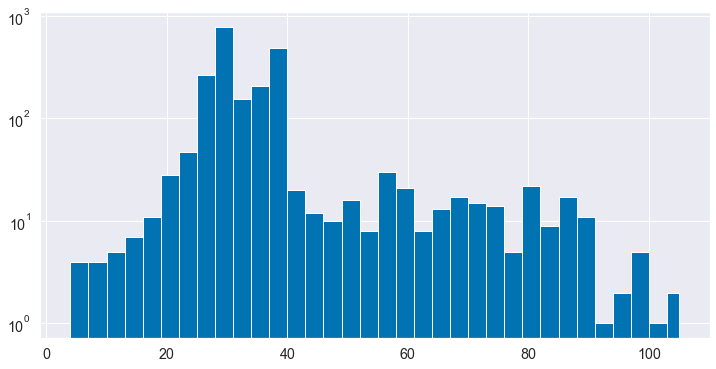

In [7]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(growth_temperatures, bins=bins, log=True);

In [8]:
def compute_inverse_probability_weights(growth_temperatures, step=3):
    min_ = int(np.floor(np.min(growth_temperatures)))
    max_ = int(np.ceil(np.max(growth_temperatures)))
    bins = list(range(min_, max_, step)) + [max_]
    total = len(growth_temperatures)
    values, _ = np.histogram(growth_temperatures, bins)
    weights_dict = {
        b: total / values[i]
        for i, b in enumerate(bins[:-1])
    }
    return weights_dict, bins

In [9]:
weights_dict, bins = compute_inverse_probability_weights(growth_temperatures)

In [10]:
weights_dict

{4: 566.25,
 7: 566.25,
 10: 453.0,
 13: 323.57142857142856,
 16: 205.9090909090909,
 19: 80.89285714285714,
 22: 48.191489361702125,
 25: 8.451492537313433,
 28: 2.9038461538461537,
 31: 14.51923076923077,
 34: 10.889423076923077,
 37: 4.641393442622951,
 40: 113.25,
 43: 188.75,
 46: 226.5,
 49: 141.5625,
 52: 283.125,
 55: 75.5,
 58: 107.85714285714286,
 61: 283.125,
 64: 174.23076923076923,
 67: 133.23529411764707,
 70: 151.0,
 73: 161.78571428571428,
 76: 453.0,
 79: 102.95454545454545,
 82: 251.66666666666666,
 85: 133.23529411764707,
 88: 205.9090909090909,
 91: 2265.0,
 94: 1132.5,
 97: 453.0,
 100: 2265.0,
 103: 1132.5}

In [11]:
def assign_weight_to_batch_values(growth_temperatures, weights_dict, bins, dtype='float32'):
    index = np.digitize(growth_temperatures, bins)
    weights_u = np.array(
        [weights_dict[bins[ix-1]] for ix in index],
        dtype=dtype,
    )
    return weights_u / np.sum(weights_u)

In [12]:
weights = assign_weight_to_batch_values(
    np.random.choice(growth_temperatures, size=64, replace=False),
    weights_dict, 
    bins,
)
len(weights)

64

In [13]:
weights

array([0.00080146, 0.0023326 , 0.02232631, 0.01330078, 0.00128102,
       0.00300546, 0.00080146, 0.00128102, 0.00400729, 0.00080146,
       0.01330078, 0.00080146, 0.00080146, 0.00128102, 0.0023326 ,
       0.0023326 , 0.00080146, 0.00080146, 0.00080146, 0.00128102,
       0.00128102, 0.00128102, 0.00300546, 0.00128102, 0.00080146,
       0.07814207, 0.00080146, 0.08930522, 0.00080146, 0.00080146,
       0.00080146, 0.00080146, 0.00080146, 0.00128102, 0.0023326 ,
       0.02083788, 0.00400729, 0.00300546, 0.62513655, 0.00300546,
       0.00128102, 0.00080146, 0.04808743, 0.00080146, 0.00128102,
       0.00400729, 0.00080146, 0.00080146, 0.00080146, 0.00300546,
       0.0023326 , 0.00080146, 0.00128102, 0.00128102, 0.00080146,
       0.00300546, 0.00128102, 0.00300546, 0.0023326 , 0.00300546,
       0.00128102, 0.00080146, 0.0023326 , 0.00080146], dtype=float32)

In [14]:
weights = assign_weight_to_batch_values(
    growth_temperatures,
    weights_dict, 
    bins,
)
len(weights)

2265

In [15]:
def mae(y_true, y_pred, weights=None):
    return np.average(np.abs(y_true - y_pred), weights=weights)

In [16]:
mean_ogt = np.mean(growth_temperatures)
mean_ogt

34.99763222958057

In [17]:
mae(growth_temperatures, mean_ogt)

8.0155055129161

In [18]:
mae(growth_temperatures, mean_ogt, weights)

29.354706465396497

In [19]:
def get_count_per_bin(growth_temperatures, step=3):
    min_ = int(np.floor(np.min(growth_temperatures)))
    max_ = int(np.ceil(np.max(growth_temperatures)))
    bins = list(range(min_, max_, step)) + [max_]
    total = len(growth_temperatures)
    return np.histogram(growth_temperatures, bins)

In [20]:
n_samples_per_bin, bins = get_count_per_bin(growth_temperatures)
n_samples_per_bin

array([  4,   4,   5,   7,  11,  28,  47, 268, 780, 156, 208, 488,  20,
        12,  10,  16,   8,  30,  21,   8,  13,  17,  15,  14,   5,  22,
         9,  17,  11,   1,   2,   5,   1,   2])

In [21]:
beta = 0.99
inv_effective_sample_fn = lambda n: (1 - beta) / (1 - beta**n)
inv_effective_weights = np.apply_along_axis(inv_effective_sample_fn, 0, n_samples_per_bin)
inv_effective_weights

array([0.25378141, 0.25378141, 0.2040402 , 0.14720028, 0.09554589,
       0.04076961, 0.02656222, 0.01072552, 0.01000394, 0.01263412,
       0.01141069, 0.01007468, 0.05491697, 0.08801645, 0.1045829 ,
       0.06732092, 0.12944095, 0.03841727, 0.0525563 , 0.12944095,
       0.08164666, 0.06367123, 0.07145836, 0.07618805, 0.2040402 ,
       0.050411  , 0.11562999, 0.06367123, 0.09554589, 1.        ,
       0.50251256, 0.2040402 , 1.        , 0.50251256])

In [22]:
inverse_frequency_fn = lambda n: 1 / n
inverse_frequency = np.apply_along_axis(inverse_frequency_fn, 0, n_samples_per_bin)
inverse_frequency

array([0.25      , 0.25      , 0.2       , 0.14285714, 0.09090909,
       0.03571429, 0.0212766 , 0.00373134, 0.00128205, 0.00641026,
       0.00480769, 0.00204918, 0.05      , 0.08333333, 0.1       ,
       0.0625    , 0.125     , 0.03333333, 0.04761905, 0.125     ,
       0.07692308, 0.05882353, 0.06666667, 0.07142857, 0.2       ,
       0.04545455, 0.11111111, 0.05882353, 0.09090909, 1.        ,
       0.5       , 0.2       , 1.        , 0.5       ])

In [23]:
np.min(inv_effective_weights), np.min(inverse_frequency)

(0.010003941149545446, 0.001282051282051282)

In [24]:
v = inv_effective_weights * 64 / np.sum(inv_effective_weights)
np.sum(v)

63.99999999999999

In [25]:
v

array([ 2.81366264,  2.81366264,  2.26218419,  1.63200268,  1.05931287,
        0.45201081,  0.29449406,  0.11891336,  0.11091323,  0.14007388,
        0.12650982,  0.11169751,  0.60886194,  0.97583426,  1.15950576,
        0.74638394,  1.43510577,  0.42593044,  0.5826893 ,  1.43510577,
        0.90521277,  0.70591996,  0.79225547,  0.84469331,  2.26218419,
        0.55890439,  1.28198434,  0.70591996,  1.05931287, 11.08695344,
        5.57133339,  2.26218419, 11.08695344,  5.57133339])

In [26]:
np.min(v), np.max(v)

(0.11091322978692074, 11.08695344453924)

In [27]:
def compute_inverse_effective_sample(
    growth_temperatures, 
    batch_size,
    step=3, 
    beta=0.99,
):
    """
    Class-balanced weighting based on inverse effective sample.
    https://arxiv.org/abs/1901.05555
    """
    min_ = int(np.floor(np.min(growth_temperatures)))
    max_ = int(np.ceil(np.max(growth_temperatures)))
    bins = list(range(min_, max_, step)) + [max_]
    values, _ = np.histogram(growth_temperatures, bins)
    inv_effective_sample_fn = lambda n: (1 - beta) / (1 - beta**n)
    inv_effective_weights = np.apply_along_axis(
        inv_effective_sample_fn, 
        axis=0, 
        arr=values,
    )
    weights_sum = np.sum(inv_effective_weights)
    weights_dict = {
        b: batch_size * inv_effective_weights[i] / weights_sum
        for i, b in enumerate(bins[:-1])
    }
    return weights_dict, bins

In [28]:
weights_dict, bins = compute_inverse_effective_sample(growth_temperatures, batch_size=302.56)

In [29]:
def assign_weight_to_batch_values(
    batch_temperatures, 
    weights_dict, 
    bins, 
    dtype='float32',
):
    index = np.digitize(batch_temperatures, bins)
    return np.array(
        [weights_dict[bins[ix-1]] for ix in index],
        dtype=dtype,
    )

In [30]:
batch_temperatures = [25, 25, 65, 101]
assign_weight_to_batch_values(batch_temperatures, weights_dict, bins)

array([ 0.56216294,  0.56216294,  4.279393  , 52.413574  ], dtype=float32)

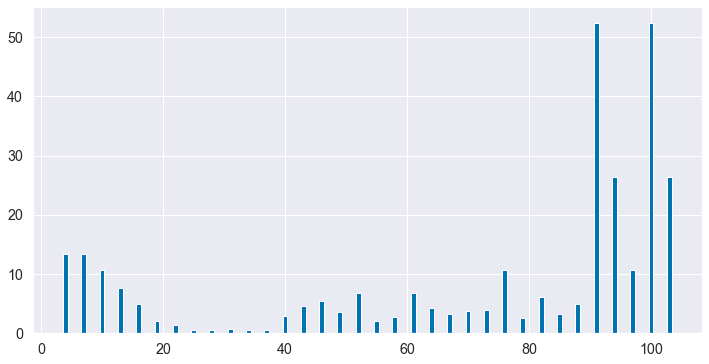

In [36]:
weights_values = [weights_dict[k] for k in sorted(weights_dict.keys())]
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    sorted(weights_dict.keys()),
    weights_values,
);

In [111]:
%%time
q = """
select t.growth_tmp 
from sequences as s 
inner join species_traits as t 
on t.species_taxid = s.species_taxid
"""
all_tmps = pd.read_sql(q, engine)['growth_tmp']

CPU times: user 13.7 s, sys: 2.05 s, total: 15.7 s
Wall time: 26.1 s


In [ ]:
sums = []
n_samples = 1000
for i in range(n_samples):
    if (i+1) % 50 == 0:
        print(f'{i+1} / {n_samples}')
    batch_tmps = np.random.choice(all_tmps, size=64, replace=False)
    w = assign_weight_to_batch_values(batch_tmps, weights_dict, bins)
    sums.append(np.sum(w))
    
np.mean(sums)